In [2]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
np.random.seed(42)
pd.set_option('display.max_columns', None)
df = pd.read_csv('dataset v1.csv')

#Convert remaining_lease into numerical remaining_lease_years
def convert_lease_to_years(lease_str):
    if not isinstance(lease_str, str):
        return np.nan
    years = 0
    months = 0
    # Use regex to find numbers associated with 'year' and 'month'
    year_match = re.search(r'(\d+)\s*year', lease_str)
    month_match = re.search(r'(\d+)\s*month', lease_str)
    if year_match:
        years = int(year_match.group(1))
    if month_match:
        months = int(month_match.group(1))
    # Return the total lease in years, or NaN if no parts were found
    if years == 0 and months == 0:
        return np.nan
    return years + months / 12.0

df['remaining_lease_years'] = df['remaining_lease'].apply(convert_lease_to_years)

#Ordinally encoded storey_range by taking the in-between storeys (floors 01-03 becomes 2)
floor_map = {'01 TO 03': 2,'04 TO 06': 5,'07 TO 09': 8,'10 TO 12': 11,'13 TO 15': 14,
    '16 TO 18': 17,'19 TO 21': 20,'22 TO 24': 23,'25 TO 27': 26,'28 TO 30': 29,
    '31 TO 33': 32,'34 TO 36': 35,'37 TO 39': 38,'40 TO 42': 41,'43 TO 45': 44,
    '46 TO 48': 47,'49 TO 51': 50,}

df['storey_ordinal'] = df['storey_range'].map(floor_map)

#Create train test splits
df.drop(columns=['Unnamed: 0','storey_range','street_name','remaining_lease','latitude','longitude','nearest_bus_stop','nearest_pei',
                   'nearest_jc','nearest_kindergarten','nearest_primary_school','nearest_secondary_school','nearest_poly',
                   'nearest_library','nearest_hospital','nearest_mall','nearest_mrt_station','nearest_sports_facility','nearest_hawker_centre'],inplace=True)
X = df.drop(columns=['resale_price'])
y = df['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Sampling using Sample Weights
X_train['combined_feature'] = X_train['town'].astype(str) + '_' + \
                            X_train['flat_type'].astype(str) + '_' + \
                            X_train['flat_model'].astype(str)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=X_train['combined_feature']  # The imbalanced feature we want to correct for
)

fit_params = {
    'regressor__sample_weight': sample_weights
}
X_train.drop(columns=['combined_feature'],inplace=True)

#One hot encode categorical columns and scale numerical columns by fit transforming on train data and transforming test data
categorical_columns = ['town', 'flat_type', 'flat_model']
numerical_columns = [
    'floor_area_sqm', 'lease_commence_date',
    'dist_bus_stop_m', 'dist_pei_m', 'dist_jc_m', 'dist_kindergarten_m',
    'dist_primary_school_m', 'dist_secondary_school_m', 'dist_poly_m',
    'dist_library_m', 'dist_mall_m', 'dist_hospital_m', 'dist_mrt_station_m',
    'dist_sports_facility_m', 'dist_hawker_centre_m',
    'remaining_lease_years','storey_ordinal',]


numerical_columns = [col for col in numerical_columns if col in X_train.columns]
categorical_columns = [col for col in categorical_columns if col in X_train.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)
    ],
    remainder='drop'
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

#Scale y_train and y_test
scaler = QuantileTransformer(output_distribution='normal')
y_train_reshaped = y_train.values.reshape(-1, 1)
y_train_scaled = scaler.fit_transform(y_train_reshaped)

y_test_reshaped = y_test.values.reshape(-1, 1)
y_test_scaled = scaler.transform(y_test_reshaped)

In [3]:
import joblib

model = joblib.load('xgb_model 24Aug25.joblib')

In [5]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.8 MB/s eta 0:00:00


--- Running Fairness Test ---
RMSE by Town:
                         rmse
town                         
ANG MO KIO       34416.038008
BEDOK            32537.580471
BISHAN           51942.500866
BUKIT BATOK      28560.880336
BUKIT MERAH      41100.760575
BUKIT PANJANG    28948.921812
BUKIT TIMAH      55647.214182
CENTRAL AREA     42710.312997
CHOA CHU KANG    24969.224702
CLEMENTI         32582.170817
GEYLANG          34318.313035
HOUGANG          34128.884595
JURONG EAST      33506.265833
JURONG WEST      26777.211044
KALLANG/WHAMPOA  38429.957364
MARINE PARADE    43377.890891
PASIR RIS        32898.882924
PUNGGOL          25601.149609
QUEENSTOWN       42029.655126
SEMBAWANG        22571.570614
SENGKANG         25405.032875
SERANGOON        36928.583297
TAMPINES         31259.672620
TOA PAYOH        39643.440009
WOODLANDS        26493.976451
YISHUN           24752.732122


Difference in RMSE between towns: $33075.64
------------------------------

--- Running Explainability Test (SHAP)

  0%|          | 0/100 [00:00<?, ?it/s]

Displaying SHAP Summary Plot...


/tmp/ipython-input-2052342240.py:67: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_processed_df.sample(100, random_state=42), show=False)


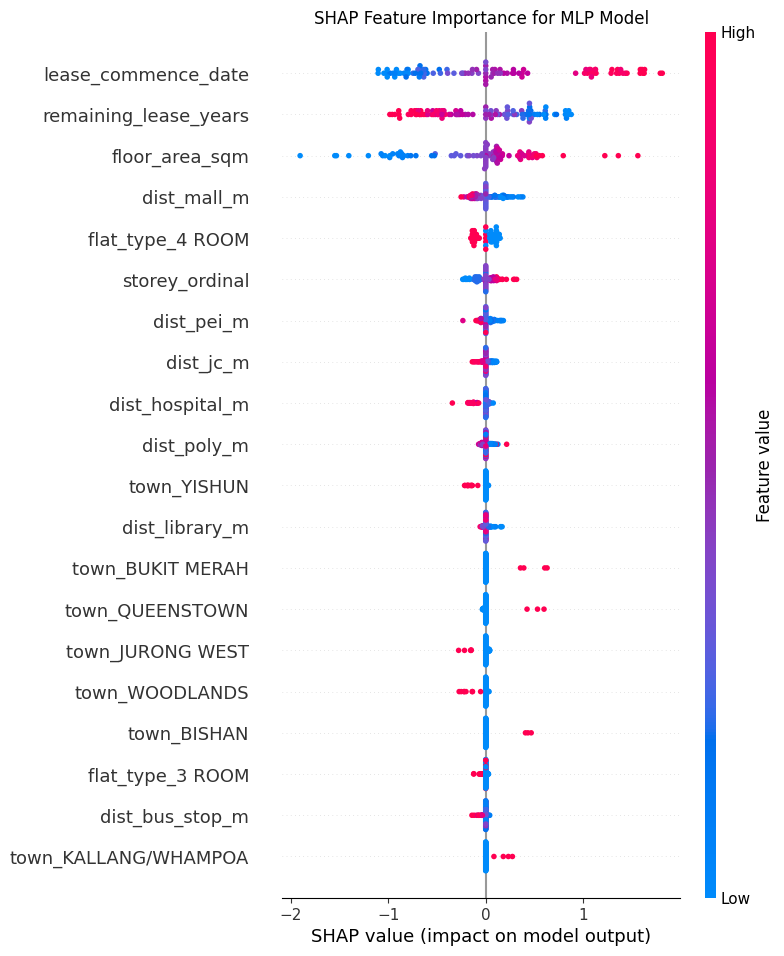

------------------------------

--- Running Robustness Test ---
Original Test Set RMSE: $31625.04
Perturbed Test Set RMSE: $35539.58
RMSE increased by: $3914.53 (12.38%)
Average prediction change after perturbation: $8971.88
------------------------------



In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from fairlearn.metrics import MetricFrame
import shap
import matplotlib.pyplot as plt

# --- Helper Function for RMSE ---
def rmse(y_true, y_pred):
    """Calculates Root Mean Squared Error."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

# --- Make Predictions on the Test Set ---
# First, get the scaled predictions from your model
y_pred_scaled = model.predict(X_test_processed)

# IMPORTANT: Inverse transform predictions and true values to get actual dollar amounts
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_actual = scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()


# --- 1. Fairness Test: Analyzing Performance by Town ---
print("--- Running Fairness Test ---")

# Use the original, un-processed X_test to get the 'town' column for grouping
sensitive_features = X_test['town']

# Create a MetricFrame to calculate RMSE for each town
grouped_on_town = MetricFrame(metrics={'rmse': rmse},
                              y_true=y_test_actual,
                              y_pred=y_pred,
                              sensitive_features=sensitive_features)

print("RMSE by Town:")
print(grouped_on_town.by_group)
print("\n")

# Check the difference between the highest and lowest RMSE among towns
# FIX: Extract the specific 'rmse' value from the returned Series before formatting
difference_value = grouped_on_town.difference(method='between_groups')['rmse']
print(f"Difference in RMSE between towns: ${difference_value:.2f}")
print("-" * 30 + "\n")


# --- 2. Explainability Test: Using SHAP ---
print("--- Running Explainability Test (SHAP) ---")
print("This may take a moment...")

# Reconstruct the feature names from the preprocessor
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
feature_names = numerical_columns + list(ohe_feature_names)

# SHAP works best on a DataFrame, so let's create one for our processed data
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)


# We use a KernelExplainer, which is model-agnostic.
# We'll use a sample of the training data as the background dataset for SHAP.
explainer = shap.KernelExplainer(model.predict, shap.sample(X_train_processed_df, 50))

# Calculate SHAP values for the test set (or a sample for speed)
shap_values = explainer.shap_values(X_test_processed_df.sample(100, random_state=42))

# Create the summary plot to show global feature importance
print("Displaying SHAP Summary Plot...")
shap.summary_plot(shap_values, X_test_processed_df.sample(100, random_state=42), show=False)
plt.title("SHAP Feature Importance for MLP Model")
plt.show()

print("-" * 30 + "\n")


# --- 3. Robustness Test: Data Perturbation ---
print("--- Running Robustness Test ---")

# Let's perturb the 'floor_area_sqm' feature by +/- 5%
X_test_perturbed = X_test.copy()
perturbation_factor = np.random.uniform(0.95, 1.05, size=X_test_perturbed.shape[0])
X_test_perturbed['floor_area_sqm'] *= perturbation_factor

# IMPORTANT: The perturbed data must be transformed using the SAME preprocessor
X_test_perturbed_processed = preprocessor.transform(X_test_perturbed)

# Make predictions on the perturbed data
y_pred_perturbed_scaled = model.predict(X_test_perturbed_processed)
y_pred_perturbed = scaler.inverse_transform(y_pred_perturbed_scaled.reshape(-1, 1)).flatten()

# Compare the original vs. perturbed RMSE
original_rmse = rmse(y_test_actual, y_pred)
perturbed_rmse = rmse(y_test_actual, y_pred_perturbed)

print(f"Original Test Set RMSE: ${original_rmse:.2f}")
print(f"Perturbed Test Set RMSE: ${perturbed_rmse:.2f}")
print(f"RMSE increased by: ${perturbed_rmse - original_rmse:.2f} ({((perturbed_rmse - original_rmse) / original_rmse) * 100:.2f}%)")

# Check the average absolute change in prediction price
avg_prediction_change = np.mean(np.abs(y_pred - y_pred_perturbed))
print(f"Average prediction change after perturbation: ${avg_prediction_change:.2f}")
print("-" * 30 + "\n")
